<a href="https://colab.research.google.com/github/pablojrios/fluence_maps/blob/master/tf2_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compute metrics across cross-validation fold predictions .csv files

In [118]:
def isGoogleColab():
    # 'ipykernel.zmqshell' runs in our server
    # 'google.colab._shell' runs in Google Colab
    return get_ipython().__class__.__module__ == 'google.colab._shell'

In [119]:
import numpy as np
import os
import pandas as pd
# Es indistinto usar las métricas de scikit learn o tensorflow
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats 

In [120]:
if isGoogleColab():
    %cd -q '/content'
    if os.path.exists('fluence_maps'):
        !rm -fr fluence_maps

    GIT_USERNAME = "pablojrios"
    GIT_TOKEN = "1d88a0b85d2b00a03796e4d8b7e5f7b249b12f9b"
    !git clone -s https://{GIT_TOKEN}@github.com/{GIT_USERNAME}/fluence_maps.git

    from google.colab import drive
    drive.mount('/content/drive')
    
    %cd -q '/content/fluence_maps'

    !ls -l '/content/drive/My Drive/Healthcare/Radioterapia/data/ciolaplata/predictions'
    
    ARG_PREDICTIONS_FILES_DIR='/content/drive/My Drive/Healthcare/Radioterapia/data/ciolaplata/predictions'

In [121]:
# Compute p-value and CI for Pearson's correlation coefficient (https://zhiyzuo.github.io/Pearson-Correlation-CI-in-Python/)
def compute_pearson_correlation_ci(y, y_hat):
    # The first step involves transformation of the correlation coefficient into a Fishers’ Z-score.
    r, p = stats.pearsonr(y, y_hat)
    r_z = np.arctanh(r)

    # calculate standard deviation se
    se = 1/np.sqrt(y.size-3)

    # CI under the transformation can be calculated as below:
    alpha = 0.05
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se

    # Finally, we can reverse the transformation by np.tanh:
    lo, hi = np.tanh((lo_z, hi_z))
    return p, lo, hi

In [122]:
# https://stats.stackexchange.com/questions/78079/confidence-interval-of-rmse
def compute_mae_ci(y, y_hat, alpha=0.95):
    n=y.size
    c1,c2 = stats.chi2.ppf([(1-alpha)/2, alpha+(1-alpha)/2], n)
    ae = abs(y - y_hat)

    lo = np.mean(np.sqrt(n/c2)*ae)
    hi = np.mean(np.sqrt(n/c1)*ae)
    mae = mean_absolute_error(y, y_hat)
    # same as above                                   
    lo = np.sqrt(n/c2)*mae
    hi = np.sqrt(n/c1)*mae
    
    return mae, lo, hi

In [123]:
def display_scatterplot(model_name, y, y_hat):
    print('Model name = %s' % model_name)
    print('size = %d' % len(y))

    # mean average error
    mae = mean_absolute_error(y, y_hat)
    _, lo, hi = compute_mae_ci(y, y_hat)
    print('MAE = %.3f, CI at 95%% = [%.3f, %.3f]' % (mae, lo, hi))

    # mean square error
    mse = mean_squared_error(y, y_hat)
    print('MSE = %.3f' % (mse))
    
    # correlación entre predichos y observados
    corr = np.corrcoef(y, y_hat)[0,1]
    # compute p-value and CI
    p, lo, hi = compute_pearson_correlation_ci(y, y_hat)
    print('Pearson correlation = %.3f (p < %f), CI at 95%% = [%.3f, %.3f]' % (corr, p, lo, hi))

    r2score = r2_score(y, y_hat)
    print('R-squared = %.3f' % (r2score))
    
    # plot calculados vs. predichos (targets)
    fig_dims = (8, 8)
    fig, ax = plt.subplots(figsize=fig_dims)
    plt.title('Actual vs. Predicted')
    plt.gca().set_aspect('equal')
    sns.scatterplot(y, y_hat, marker='o', ax=ax)
    ax.set(xlabel="Actual", ylabel = "Predicted")
    plt.figure(figsize=(15, 15))
    minimum = int(np.min([y.min(), y_hat.min()]))
    ax.set_xlim([minimum, 100])
    ax.set_ylim([minimum, 100])
    ax.plot([minimum, 100], [minimum, 100], ls="--", c=".7")
    ax.plot([minimum+3, 100], [minimum, 97], ls="--", c=".4")
    ax.plot([minimum, 97], [minimum+3, 100], ls="--", c=".4")
    plt.show()

In [124]:
#============================DEFINE YOUR ARGUMENTS==============================
if not isGoogleColab():
    # base data directory
    ARG_PREDICTIONS_FILES_DIR='/hdd/data/radioterapia/ciolaplata/predictions'

# To display in the scatter plot
# ARG_MODEL_NAME = '2019+2017 ResNet18+BN cross-validation'
# ARG_MODEL_NAME = '2019+2017 Ensemble (VGG16, ResNet18 with BN, MobileNetV2) cross-validation'
# ARG_MODEL_NAME = '2019+2017 MobileNetV2 cross-validation'
# ARG_MODEL_NAME = '2019+2017 Ensemble (ResNet18 with BN, MobileNetV2) cross-validation'
# ARG_MODEL_NAME = '2019+2017 VGG16 medium, cross-validation'
ARG_MODEL_NAME = '2019-2017, ResNet18, NO transfer learning'
# file name example: predicted_gamma_1612479698.23456.validation.csv
vgg16 = {
    0: '1612494638.23456',
    1: '1612496273.23456',
    2: '1612497448.23456',
    3: '1612498850.23456',
    4: '1612499915.23456'
}
resnet18 = {
    0: '1612475423.23456',
    1: '1612476739.23456',
    2: '1612478852.23456',
    3: '1612485107.23456',
    4: '1612485908.23456'
}
resnet18bn = {
    0: '1612481240.23456',
    1: '1612480461.23456',
    2: '1612479698.23456',
    3: '1612482315.23456',
    4: '1612483273.23456'
}

mobilenetv2 = {
    0: '1612656464.mobilenetV2.23456',
    1: '1612650230.mobilenetV2.23456',
    2: '1612652753.mobilenetV2.23456',
    3: '1612653996.mobilenetV2.23456',
    4: '1612655112.mobilenetV2.23456',
}

vgg16_small = {
    0: '1612558816.vgg16.23456',
    1: '1612559292.vgg16.23456',
    2: '1612559663.vgg16.23456',
    3: '1612560497.vgg16.23456',
    4: '1612560724.vgg16.23456'
}

vgg16_medium = {
    0: '1612561743.vgg16.23456',
    1: '1612562226.vgg16.23456',
    2: '1612563707.vgg16.23456',
    3: '1612564131.vgg16.23456',
    4: '1612565417.vgg16.23456'
}

resnet18_2017 = {
    0: '1612458936.23456',
    1: '1612460107.23456',
    2: '1612462527.23456',
    3: '1612464584.23456',
    4: '1612466859.23456'
}

no_transfer_learning = {
    0: '1612828211.resnet18.23456',
    1: '1612829512.resnet18.23456',
    2: '1612832074.resnet18.23456',
    3: '1612838620.resnet18.23456',
    4: '1612839805.resnet18.23456'
}

# this is a single model
# ARG_MODEL_PREDICTIONS = resnet18bn

# this is an ensemble of models
# (vgg16, resnet18bn) es el mejor ensamble
ARG_MODEL_PREDICTIONS = (vgg16, resnet18bn)

ARG_FILTER_BY_MEASURED_GAMMA=False
# include maps with measured (actual) gamma values lower than ARG_FILTER_GAMMA_VALUE
ARG_FILTER_MEASURED_GAMMA_VALUE=95.0

In [125]:
pd.options.display.max_colwidth = 120

In [126]:
def get_model_predictions(model_predictions, path):
    files = [f'predicted_gamma_{model_predictions[fold]}.validation.csv' for fold in model_predictions]
    
    df_all = pd.DataFrame()
    for file in files:
        full_filename = os.path.join(path, file)
        df = pd.read_csv(full_filename, header=0)
        print(f'predictions file {full_filename} has {len(df)} rows.')
        df_all = df_all.append(df)
    return df_all

predictions file /hdd/data/radioterapia/ciolaplata/predictions/predicted_gamma_1612494638.23456.validation.csv has 854 rows.
predictions file /hdd/data/radioterapia/ciolaplata/predictions/predicted_gamma_1612496273.23456.validation.csv has 854 rows.
predictions file /hdd/data/radioterapia/ciolaplata/predictions/predicted_gamma_1612497448.23456.validation.csv has 854 rows.
predictions file /hdd/data/radioterapia/ciolaplata/predictions/predicted_gamma_1612498850.23456.validation.csv has 853 rows.
predictions file /hdd/data/radioterapia/ciolaplata/predictions/predicted_gamma_1612499915.23456.validation.csv has 853 rows.
predictions file /hdd/data/radioterapia/ciolaplata/predictions/predicted_gamma_1612481240.23456.validation.csv has 854 rows.
predictions file /hdd/data/radioterapia/ciolaplata/predictions/predicted_gamma_1612480461.23456.validation.csv has 854 rows.
predictions file /hdd/data/radioterapia/ciolaplata/predictions/predicted_gamma_1612479698.23456.validation.csv has 854 rows.


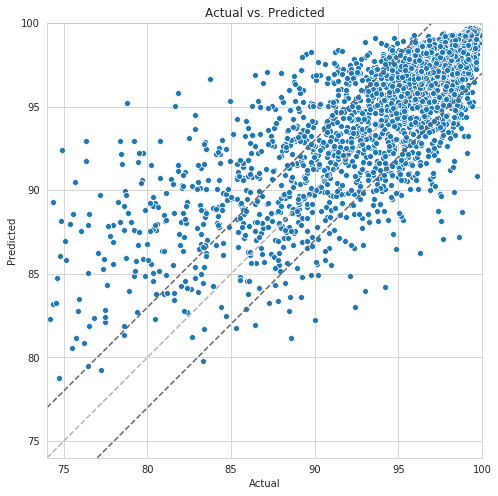

<Figure size 1080x1080 with 0 Axes>

In [127]:
if type(ARG_MODEL_PREDICTIONS)==tuple:
    df1 = get_model_predictions(ARG_MODEL_PREDICTIONS[0], ARG_PREDICTIONS_FILES_DIR)
    df2 = get_model_predictions(ARG_MODEL_PREDICTIONS[1], ARG_PREDICTIONS_FILES_DIR)
    # df3 = get_model_predictions(ARG_MODEL_PREDICTIONS[2], ARG_PREDICTIONS_FILES_DIR)
    
    # print('First map in each fold in first model')
    # df1['filename'][0]  
    # print('First map in each fold in second model')
    # df2['filename'][0]    
    
    # check
    check = all(df1['filename'][223]==df2['filename'][223])
    assert check, 'predictions are not aligned in across models'

    df = pd.DataFrame()
    df['actual gamma'] = df1['actual gamma'] # el actual es igual en cualquiera de los modelos :-)
    df['predicted gamma'] = (df1['predicted gamma'] + df2['predicted gamma'])/2
    # df['predicted gamma'] = (df1['predicted gamma'] + df2['predicted gamma'] + df3['predicted gamma'])/3

else:
    df = get_model_predictions(ARG_MODEL_PREDICTIONS, ARG_PREDICTIONS_FILES_DIR)

    
if ARG_FILTER_BY_MEASURED_GAMMA:
    # df = df.loc[df['actual gamma'] < ARG_FILTER_MEASURED_GAMMA_VALUE]
    # df = df.loc[(df['actual gamma'] >= ARG_FILTER_MEASURED_GAMMA_VALUE) & (df['predicted gamma'] > 98.0)]
    pass

p98 = len(df.loc[df['predicted gamma'] > 98.0].index)
print(f'Number of maps with predicted gamma > 98% is {p98}')

# En df tengo el gamma actual y el gamma predicho tanto para un modelo simple como para un ensamble de modelos.
y = df['actual gamma']
y_hat = df['predicted gamma']
    
display_scatterplot(ARG_MODEL_NAME, y, y_hat)

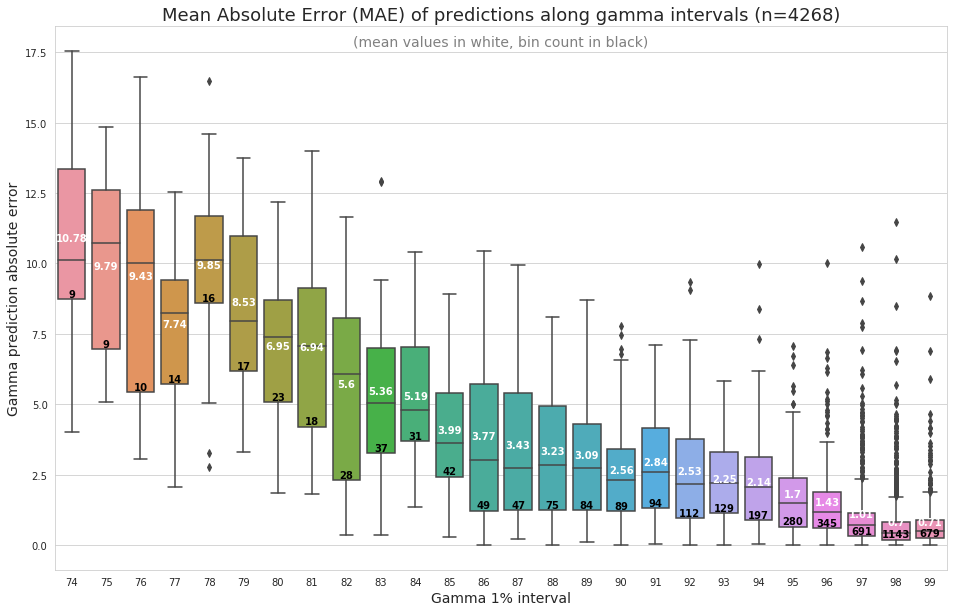

{'font.size': 10.0,
 'axes.labelsize': 'medium',
 'axes.titlesize': 'large',
 'xtick.labelsize': 'medium',
 'ytick.labelsize': 'medium',
 'legend.fontsize': 'medium',
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

In [128]:
# gamma interval for actual values
df['gamma interval'] = [str(int(value)) for value in df['actual gamma']]
df['gamma error'] = abs(df['actual gamma'] - df['predicted gamma'])
n = df['gamma error'].count()

fig_dims = (16, 10)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title(f'Mean Absolute Error (MAE) of predictions along gamma intervals (n={n})', fontsize=18)

sns.set_style("whitegrid")
ax = sns.boxplot(x="gamma interval", y="gamma error", data=df)
ax.set_xlabel("Gamma 1% interval", fontsize=14)
ax.set_ylabel("Gamma prediction absolute error", fontsize=14)

means = df.groupby(['gamma interval'])['gamma error'].mean()
means = round(means, 2)
counts = df.groupby(['gamma interval'])['gamma error'].count()
firstquartile = df.groupby(['gamma interval'])['gamma error'].quantile([0.25])

ax.text(ax.get_xticks().mean(), df['gamma error'].max()*1.01, "(mean values in white, bin count in black)", horizontalalignment='center', fontsize=14, color='grey')

vertical_offset_mean = df['gamma error'].mean() * 0.05 # offset from mean for display

for xtick in ax.get_xticks():
    ax.text(xtick, means[xtick], means[xtick], 
            horizontalalignment='center', size=10, color='white', weight='semibold')
    ax.text(xtick, firstquartile[xtick] + vertical_offset_mean, counts[xtick], 
            horizontalalignment='center', size=10, color='black', weight='semibold')

plt.show()
sns.plotting_context()

### Auxiliary computation

In [129]:
r, p = stats.pearsonr(y, y_hat)
print(r, p)
r_z = np.arctanh(r)
print(r_z)

se = 1/np.sqrt(y.size-3)
print(se)

alpha = 0.05
z = stats.norm.ppf(1-alpha/2)
lo_z, hi_z = r_z-z*se, r_z+z*se
print(lo_z, hi_z)

lo, hi = np.tanh((lo_z, hi_z))
lo, hi

0.8285108058349469 0.0
1.1833684452034163
0.015312301868469587
1.1533568850208105 1.2133800053860222


(0.8188630924971348, 0.8376905175947272)

In [130]:
# https://stats.stackexchange.com/questions/78079/confidence-interval-of-rmse
n=y.size
alpha = 0.95
c1,c2 = stats.chi2.ppf([(1-alpha)/2, alpha+(1-alpha)/2], n)
ae = abs(y - y_hat)

np.mean(np.sqrt(n/c2)*ae), np.mean(np.sqrt(n/c1)*ae)
mae = mean_absolute_error(y, y_hat)
np.sqrt(n/c2)*mae, np.sqrt(n/c1)*mae

(1.5921058860266775, 1.661117080356376)

In [131]:
df.shape

(4268, 4)

In [132]:
# '*' in front of compute_mae_cis() is the unpacking operator to then unpack the tuple.
mae_cis = [(g[0], len(g[1]), *compute_mae_ci(g[1]['actual gamma'], g[1]['predicted gamma'], alpha=0.99)) for g in df.groupby(['gamma interval'])]

In [133]:
mae_cis
df2 = pd.DataFrame(mae_cis, columns=('interval', 'count', 'mae', 'lo', 'hi'))
df2

,interval,count,mae,lo,hi
0,74,9,10.776022,6.656129,24.543606
1,75,9,9.793860,6.049467,22.306621
2,76,10,9.431458,5.942654,20.312758
3,77,14,7.736063,5.172228,14.339617
4,78,16,9.852942,6.732660,17.380057
5,79,17,8.531743,5.885940,14.737738
6,80,23,6.950810,5.015107,10.954281
7,81,18,6.935208,4.827015,11.755524
8,82,28,5.600482,4.149995,8.395027
9,83,37,5.363670,4.114292,7.567843


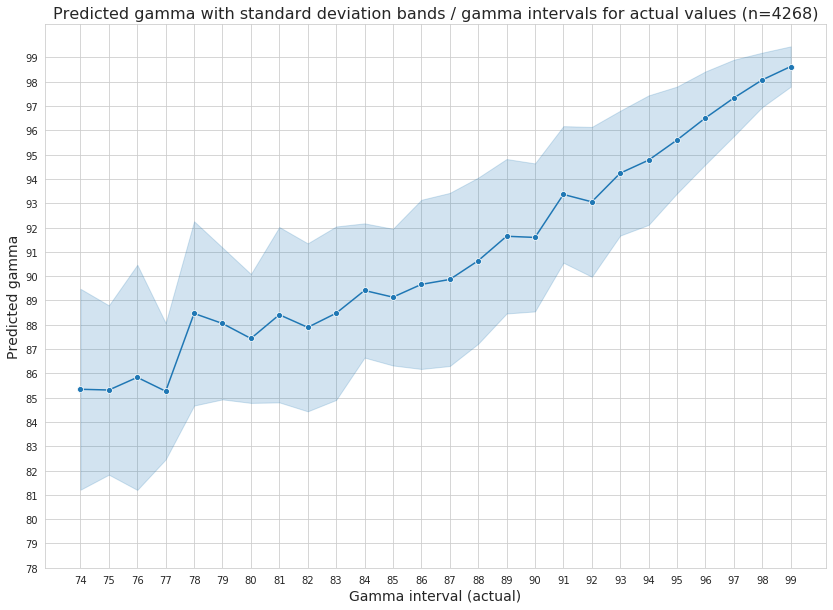

In [134]:
fig_dims = (14, 10)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title(f'Predicted gamma with standard deviation bands / gamma intervals for actual values (n={n})', fontsize=16)

#p1 = sns.lineplot(data=df2, x='interval', y='mae', color='red')
#p2 = sns.lineplot(data=df2, x='interval', y='lo', color='gray')
#p3 = sns.lineplot(data=df2, x='interval', y='hi', color='gray')
#p3.set_xlabel("Gamma 1% interval", fontsize=14)
#p3.set_ylabel("MAE", fontsize=14)

ax = sns.lineplot(data=df, x='gamma interval', y='predicted gamma', ci='sd', marker='o')
ax.set_xlabel("Gamma interval (actual)", fontsize=14)
ax.set_ylabel("Predicted gamma", fontsize=14)
min = df['predicted gamma'].astype(int).min()
max = df['predicted gamma'].astype(int).max()+1
ax.set_yticks(np.arange(min, max, 1))

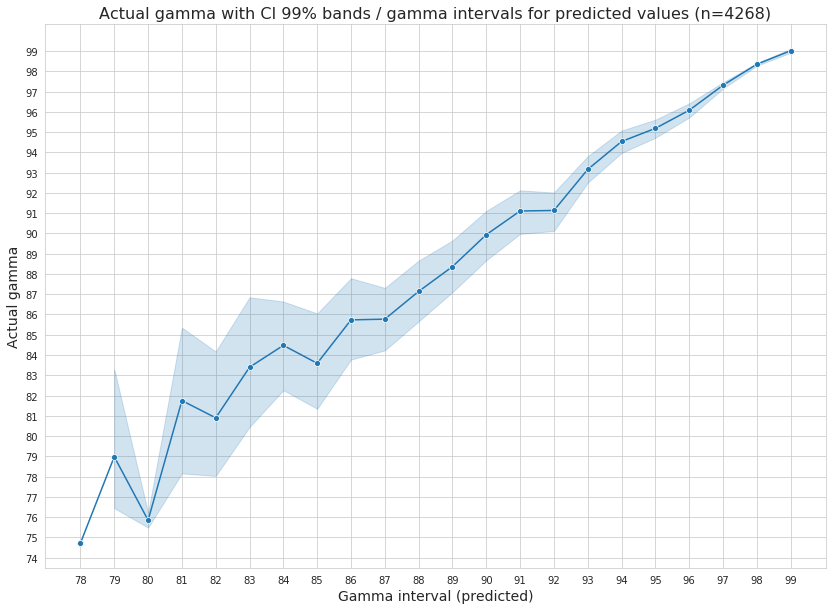

In [135]:
fig_dims = (14, 10)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title(f'Actual gamma with CI 99% bands / gamma intervals for predicted values (n={n})', fontsize=16)

# gamma intervals for predicted values
df['gamma interval'] = [str(int(value)) for value in df['predicted gamma']]

ax = sns.lineplot(data=df, x='gamma interval', y='actual gamma', ci=99, marker='o')
ax.set_xlabel("Gamma interval (predicted)", fontsize=14)
ax.set_ylabel("Actual gamma", fontsize=14)
min = df['actual gamma'].astype(int).min()
max = df['actual gamma'].astype(int).max()+1
ax.set_yticks(np.arange(min, max, 1))

In [136]:
if isGoogleColab():
    drive.flush_and_unmount()
    print('All changes made in this colab session should now be visible in Drive.')